This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1]:
# Generic imports
import copy
import os
import scipy.interpolate
from mpl_toolkits.mplot3d import Axes3D
from numpy import \
matrix, linspace, meshgrid, sin, cos, array, sqrt, pi, diff, mean, median, std, arcsin, zeros, random, \
size, reshape, shape, vstack, eye, diag, nan_to_num, ones, loadtxt, savetxt, append, squeeze
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image, ImageFont, ImageDraw
import f90nml

# Application-specific imports
import facetbrightnessstuff9 as fbs
import imagestuff as ims
import gradstuff as gds

# Graphics imports and parameters
%matplotlib notebook
fontsize = 20
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

CUDA not available.


In [2]:
# Specify the input data

# Assume all the data are in the same folder
crystalfolder = 'crystals'


# Each block specifies a surface to be retrieved
#f1 = '2016-08-09_ice1'
#case = 'case1'
#imageroot = '/2016-08-09_ice1_full2'
#Segmentnamelist = 'Segments1.nml'

# f1 = '2016-08-09_ice1'
# case = 'case1.26'
# imageroot = '/2016-08-09_ice1_rough26'
# Segmentnamelist = 'Segments2.nml'

# f1 = '2016-06-30_ice4'
# case = 'case4_corner'
# imageroot = '/2016-06-30_ice4_full2'
# Segmentnamelist = 'Segments1.nml'

# f1 = '2016-06-30_ice4'
# case = 'case4.1'
# imageroot = '/2016-06-30_ice4_rough1'
# Segmentnamelist = 'Segments1.nml'

#f1 = '2017-06-14_ice5'
#case = 'case1'
#imageroot = '/Figure'
#Segmentnamelist = 'Segments1.nml'

# f1 = '2017-06-14_ice5'
# case = 'case1.3'
# imageroot = '/Figure'
# Segmentnamelist = 'Segments1.nml'

# f1 = '2017-06-14_ice5_alt'
# case = 'case1.3'
# imageroot = '/Figure'
# Segmentnamelist = 'Segments1.nml'

f1 = '2017-06-26_ice4'
case = 'case4.2'
imageroot = '/Figure'
Segmentnamelist = 'Segments.nml'

In [3]:
# These are derivative names
Calibrationfile = crystalfolder+'/'+f1+'/Calibration.nml'
surfaceroot = crystalfolder+'/'+f1+'/'+case
Segmentfile = surfaceroot+'/'+Segmentnamelist
SEMSegmentjpgfile = surfaceroot+'/SEMSegments.jpg'
Retrievedjpgfile = surfaceroot+'/Retrieved.jpg'
Compressedfilename = surfaceroot+'/retrieved'

In [4]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2(surfaceroot, '/SEMimages', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

Filename, dx and dy crystals/2017-06-26_ice4/case4.2/SEMimages/Figure-D.bmp 0.9971733 0.9971733


<IPython.core.display.Javascript object>


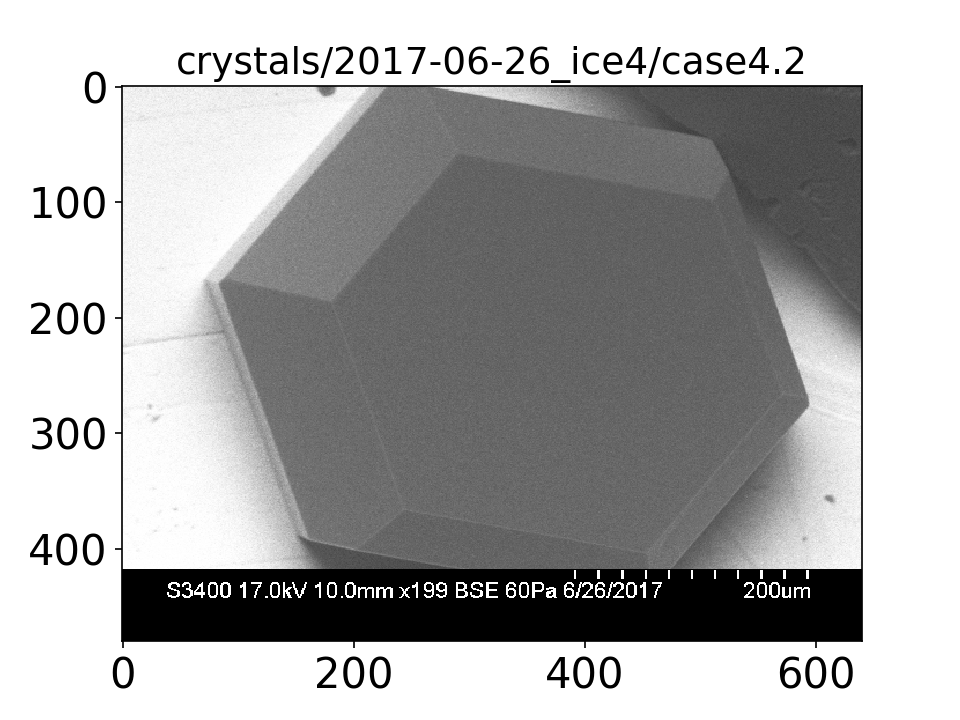

In [7]:
# Show the just image (in case we want to look at it before defining the segments)
fig, ax = plt.subplots()
ax.set_title(surfaceroot,fontsize=fontsize*0.9)
#Filename = surfaceroot+'/SEMimages'+imageroot+'-B.bmp'
im = Image.open(Filename)
ny_im,nx_im = np.shape(im)

Iwantmicrons = False
if Iwantmicrons:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255, extent=[0,nx_im*dx,0,ny_im*dy])
    ax.set_xlabel(r'$x \ (\mu m)$',fontsize=fontsize*1.1)
    ax.set_ylabel(r'$y \ (\mu m)$',fontsize=fontsize*1.1)
else:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
ax.set_title(surfaceroot,fontsize=fontsize*0.9)

<IPython.core.display.Javascript object>


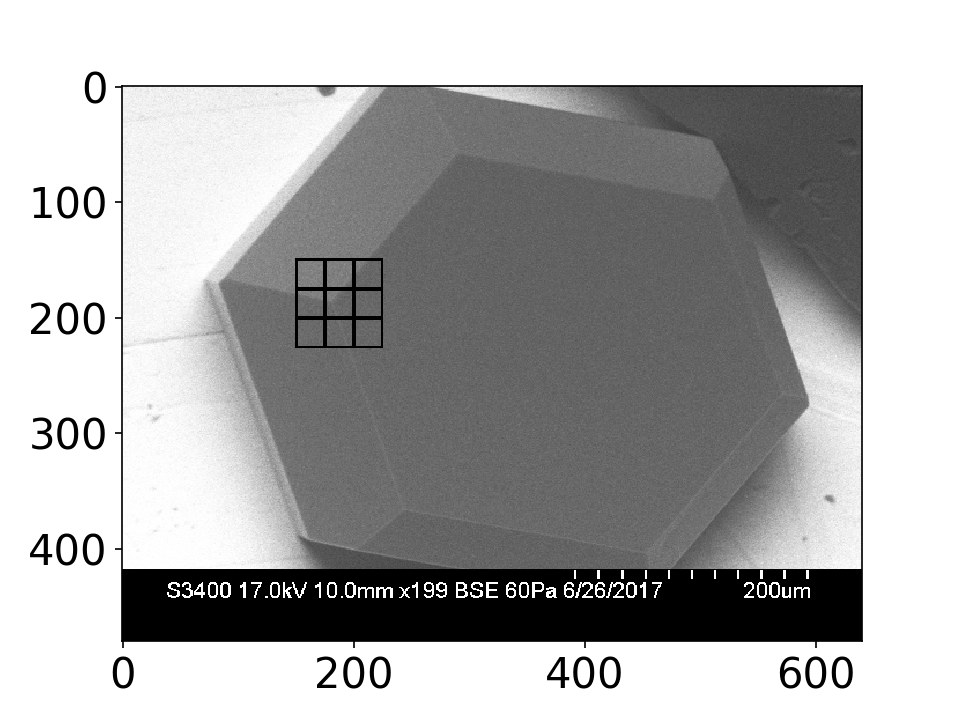

In [8]:
# Show the image with segment data
fig, ax = plt.subplots()

# Just echo input data files  
#%cat $Segmentfile

# Extract
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments
draw = ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)

if Iwantmicrons:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255, extent=[0,nx_im*dx,0,ny_im*dy])
    ax.set_xlabel(r'$x \ (\mu m)$',fontsize=fontsize*1.1)
    ax.set_ylabel(r'$y \ (\mu m)$',fontsize=fontsize*1.1)
else:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)

# Save a copy
fig.savefig(SEMSegmentjpgfile)

In [9]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)
#%cat $Calibrationfile

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']


crystals/2017-06-26_ice4/Calibration.nml


In [10]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = meshgrid(nxi,nyi)
theta = 15*pi/180
sA = (-nxigrid*sin(theta)+cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*sin(theta)+cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*sin(theta)+cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*sin(theta)+cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [11]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [12]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
fbs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [13]:
# Create a blank slate
solution = zeros(cA.shape)

In [14]:
# Generic retrieval parameters
maxiter = 5 #I ran it for 8 iterations and the error runs away to larger numbers after the fourth iteration
tolerance = 10

In [21]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
noiseamp = 5.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = zeros(cA.shape)

Std deviation in input signal is 2.23606797749979
Std deviation in a priori is 15.0


In [22]:
# Loop to retrieve each segment
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    vartemp_long = reshape(vartemp,nzpts+1,0)
    Sa = diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    settemp_long = reshape(settemp,nzpts+1,0)
    settemp_longminus1 = settemp_long[:-1]
    z_start = matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = matrix(eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print("for", nx1, ny1)
    print("Segment:", isegment+1, "of", nsegments)
    print('')
    z_retrieved = fbs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)

for 150 150
Segment: 1 of 9

statistics of observed intensities (detector B):
mean = 74.4976
max = 88.0
min = 63.0
iteration, di2 0 [[ 237838.80615045]]
iteration, di2 1 [[ 20930.25800634]]
iteration, di2 2 [[ 3916.02693098]]
iteration, di2 3 [[ 424.37438452]]
iteration, di2 4 [[ 333.35841126]]
for 150 175
Segment: 2 of 9

statistics of observed intensities (detector B):
mean = 92.9168
max = 112.0
min = 65.0
iteration, di2 0 [[ 276469.84702934]]
iteration, di2 1 [[ 23397.54216175]]
iteration, di2 2 [[ 3801.95853549]]
iteration, di2 3 [[ 395.68378415]]
iteration, di2 4 [[ 134.39523695]]
Noverlap = 26
for 150 200
Segment: 3 of 9

statistics of observed intensities (detector B):
mean = 98.3472
max = 113.0
min = 84.0
iteration, di2 0 [[ 293046.53338258]]
iteration, di2 1 [[ 25135.29284151]]
iteration, di2 2 [[ 3928.34193455]]
iteration, di2 3 [[ 253.61675948]]
iteration, di2 4 [[ 68.55111197]]
Noverlap = 26
for 175 150
Segment: 4 of 9

statistics of observed intensities (detector B):
mean 

75
75


<IPython.core.display.Javascript object>


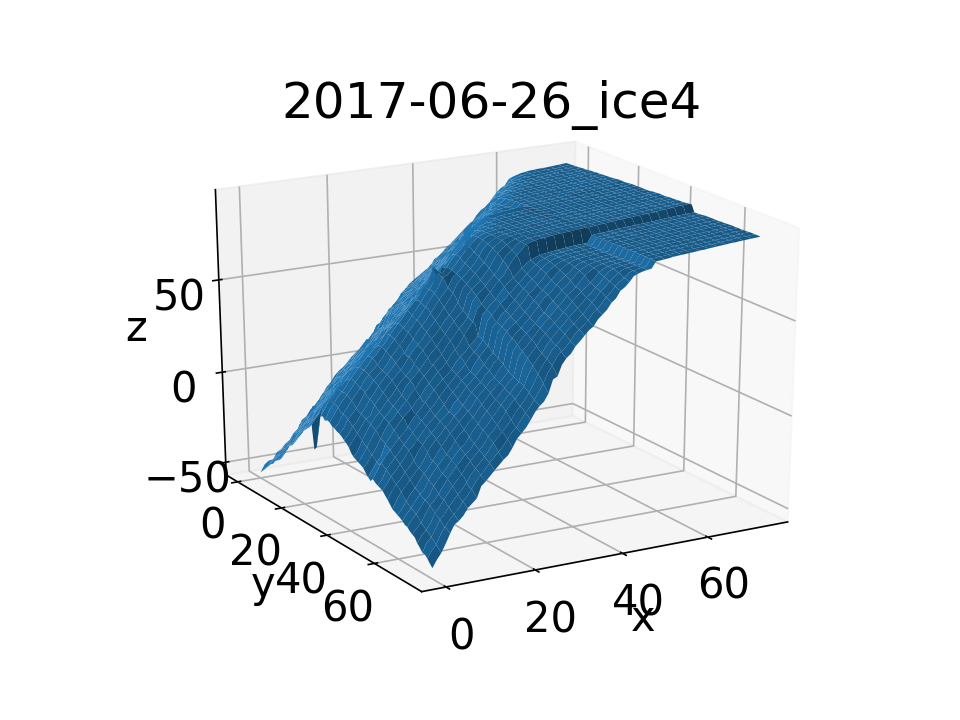

In [23]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(f1)
ax.view_init(azim=-120,elev=22)

#save an image
fig.savefig(Retrievedjpgfile)

In [24]:
# Save this data
print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=surfaceroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving crystals/2017-06-26_ice4/case4.2/retrieved
